In [ ]:
# ---------------------
# Part 1: Enhanced Profiling
# ---------------------

import torch
import torch.profiler as profiler
import pandas as pd
import numpy as np
from transformers import (
    AutoModelForCausalLM, AutoModelForSeq2SeqLM,
    AutoTokenizer, BloomForCausalLM
)
from transformers.models.bart.modeling_bart import shift_tokens_right
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pynvml

# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Configuration
MODEL_CONFIG = {
    "Decoder": [
        ("facebook/opt-350m", AutoModelForCausalLM, False),
        ("bigscience/bloom-560m", BloomForCausalLM, False)
    ],
    "Encoder-Decoder": [
        ("t5-small", AutoModelForSeq2SeqLM, True),
        ("facebook/bart-base", AutoModelForSeq2SeqLM, True)
    ]
}
WORKLOADS = ["summarization", "translation", "qa", "generation"]
BATCH_SIZES = [1, 8, 32, 128]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def setup_model(model_name, model_class):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name)
    return model, tokenizer

def get_sample_input(workload):
    samples = {
        "summarization": "Artificial Intelligence is transforming industries through machine learning...",
        "translation": "The quick brown fox jumps over the lazy dog. Translate to French:",
        "qa": "Context: Paris is the capital of France. Question: What is the capital of France?",
        "generation": "In a future where AI dominates society,"
    }
    return samples.get(workload, "Hello, how are you?")

def enhanced_profile(model, tokenizer, batch_size, workload, is_encoder_decoder):
    try:
        text = get_sample_input(workload)
        inputs = tokenizer(
            [text] * batch_size,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(DEVICE)

        # Handle encoder-decoder models
        if is_encoder_decoder:
            # Generate proper decoder inputs for BART/T5
            labels = inputs["input_ids"].clone()
            decoder_input_ids = shift_tokens_right(
                labels,
                pad_token_id=model.config.pad_token_id,
                decoder_start_token_id=model.config.decoder_start_token_id if hasattr(model.config, 'decoder_start_token_id') else 0
            )
            inputs["decoder_input_ids"] = decoder_input_ids

        # Memory tracking
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        mem_before = torch.cuda.memory_allocated()

        # Profiling context
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)

        with profiler.profile(
            activities=[profiler.ProfilerActivity.CUDA],
            record_shapes=True,
            profile_memory=True,
            with_flops=True
        ) as prof:
            torch.cuda.synchronize()
            start_event.record()

            with torch.no_grad():
                _ = model(**inputs)

            end_event.record()
            torch.cuda.synchronize()

        # Calculate metrics
        latency = start_event.elapsed_time(end_event) / 1000
        mem_after = torch.cuda.memory_allocated()
        peak_mem = torch.cuda.max_memory_allocated() - mem_before

        # Bandwidth metrics
        bw_metrics = {
            'dram_read': sum(evt.flops for evt in prof.key_averages() if 'dram_read' in evt.key),
            'dram_write': sum(evt.flops for evt in prof.key_averages() if 'dram_write' in evt.key)
        }

        # GPU utilization
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        util = pynvml.nvmlDeviceGetUtilizationRates(handle)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        pynvml.nvmlShutdown()

        return {
            "model": model.config.name_or_path,
            "architecture": "Encoder-Decoder" if is_encoder_decoder else "Decoder",
            "workload": workload,
            "batch_size": batch_size,
            "latency": latency,
            "peak_memory": peak_mem,
            "memory_bandwidth": bw_metrics['dram_read'] + bw_metrics['dram_write'],
            "parameters": sum(p.numel() for p in model.parameters()),
            "success": True
        }

    except Exception as e:
        print(f"Error profiling {model.config.name_or_path} bs:{batch_size}: {str(e)}")
        return {
            "model": model.config.name_or_path,
            "architecture": "Encoder-Decoder" if is_encoder_decoder else "Decoder",
            "workload": workload,
            "batch_size": batch_size,
            "success": False
        }

In [ ]:
# ---------------------
# Part 2: Robust Profiling Pipeline
# ---------------------

def run_profiling_pipeline():
    metrics = []

    for arch_type, models in MODEL_CONFIG.items():
        for model_config in models:
            model_name, model_class, is_encdec = model_config
            try:
                model, tokenizer = setup_model(model_name, model_class)
                model.to(DEVICE)

                for workload in WORKLOADS:
                    for batch_size in BATCH_SIZES:
                        result = enhanced_profile(
                            model, tokenizer, batch_size, workload, is_encdec
                        )
                        if result['success']:
                            metrics.append(result)
                            print(f"✓ {model_name} {workload} bs:{batch_size}")
                        else:
                            print(f"× {model_name} bs:{batch_size}")
                        torch.cuda.empty_cache()

                del model
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"Initialization error {model_name}: {str(e)}")

    df = pd.DataFrame(metrics)
    df.to_csv("llm_metrics.csv", index=False)
    return df

In [ ]:
# ---------------------
# Part 3: Optimized Analytical Model
# ---------------------

class LLMAnalyzer:
    def __init__(self):
        self.models = {
            'latency': RandomForestRegressor(n_estimators=200, random_state=42),
            'peak_memory': RandomForestRegressor(n_estimators=200, random_state=42),
            'memory_bandwidth': RandomForestRegressor(n_estimators=200, random_state=42)
        }

    def preprocess(self, df):
        df = df[df['success'] & (df['latency'] > 0)].copy()

        # Enhanced transformations
        df['mem_intensity'] = df['peak_memory'] / df['batch_size']
        df['bw_utilization'] = df['memory_bandwidth'] / (df['parameters'] * df['batch_size'] + 1e-8)

        # Log transforms with epsilon
        df['log_batch'] = np.log(df['batch_size'] + 1e-8)
        df['log_params'] = np.log(df['parameters'] + 1e-8)

        # Categorical encoding
        df['arch_code'] = df['architecture'].map({'Decoder':0, 'Encoder-Decoder':1})
        df['workload_code'] = df['workload'].astype('category').cat.codes

        return df[['log_batch', 'log_params', 'arch_code',
                 'workload_code', 'mem_intensity', 'bw_utilization']], \
               df[['latency', 'peak_memory', 'memory_bandwidth']]

    def train_evaluate(self, test_size=0.2):
        # Load and process data
        df = pd.read_csv("llm_metrics.csv")
        X, y = self.preprocess(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Store for visualizations
        self.df = df
        self.X_test = X_test
        self.y_test = y_test
        self.feature_names = X.columns.tolist()

        # Apply regularization and train models
        prediction_results = {}
        for target in self.models:
            self.models[target] = RandomForestRegressor(
                n_estimators=200,
                max_depth=8,
                min_samples_split=5,
                random_state=42
            )
            self.models[target].fit(X_train, y_train[target])

            # Store predictions for visualization
            y_pred = self.models[target].predict(X_test)
            prediction_results[target] = y_pred

        self.predictions = prediction_results

        # Enhanced evaluation
        results = {}
        for target in y.columns:
            y_pred = self.models[target].predict(X_test)
            results[target] = {
                'MAE': mean_absolute_error(y_test[target], y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test[target], y_pred)),
                'R2': r2_score(y_test[target], y_pred)
            }
        return results

    def predict(self, config):
        # Create feature dict for new config
        input_data = {
            'log_batch': np.log(config['batch_size']),
            'log_params': np.log(config['parameters']),
            'arch_code': 0 if config['architecture'] == 'Decoder' else 1,
            'workload_code': WORKLOADS.index(config['workload']),
            'mem_intensity': config.get('mem_intensity', 0),
            'bw_utilization': config.get('bw_utilization', 0)
        }
        return {
            target: model.predict(pd.DataFrame([input_data]))[0]
            for target, model in self.models.items()
        }

    def visualize_results(self):
        """Create comprehensive visualizations of model performance"""
        # Make sure we have predictions
        if not hasattr(self, 'predictions'):
            print("No predictions available. Run train_evaluate first.")
            return

        # Visualization 1: Actual vs Predicted Latency
        plt.figure(figsize=(6, 4))
        actual = self.y_test['latency'].values
        predicted = self.predictions['latency']

        scatter = plt.scatter(actual, predicted, alpha=0.7, color='#36a9e1', s=50)

        # Ideal line
        min_val = min(actual.min(), predicted.min())
        max_val = max(actual.max(), predicted.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

        plt.xlabel('Actual Latency (s)', fontsize=10)
        plt.ylabel('Predicted Latency (s)', fontsize=10)
        plt.title('Actual vs Predicted Latency', fontsize=10)
        plt.tight_layout()
        plt.savefig('actual_vs_predicted.png', dpi=300)
        plt.show()

        # Visualization 2: Residuals vs Predicted
        plt.figure(figsize=(6, 4))
        residuals = actual - predicted

        plt.scatter(predicted, residuals, alpha=0.7, color='#36a9e1', s=50)
        plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

        plt.xlabel('Predicted Latency (s)', fontsize=10)
        plt.ylabel('Residuals', fontsize=10)
        plt.title('Residuals vs Predicted Latency', fontsize=10)
        plt.tight_layout()
        plt.savefig('residuals_vs_predicted.png', dpi=300)
        plt.show()

        # Visualization 3: Residuals Distribution
        plt.figure(figsize=(6, 4))
        sns.histplot(residuals, kde=True, color='#36a9e1')
        plt.axvline(x=0, color='r', linestyle='--', linewidth=2)

        plt.xlabel('Residual Value', fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
        plt.title('Residuals Distribution', fontsize=10)
        plt.tight_layout()
        plt.savefig('residuals_distribution.png', dpi=300)
        plt.show()

        # Visualization 4: Latency by Architecture
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='architecture', y='latency', data=self.df)

        plt.xlabel('Model Architecture', fontsize=10)
        plt.ylabel('Latency (s)', fontsize=10)
        plt.title('Latency Distribution by Architecture Type', fontsize=16)
        plt.tight_layout()
        plt.savefig('latency_by_architecture.png', dpi=300)
        plt.show()

        # Visualization 5: Feature Importance for Latency
        plt.figure(figsize=(6, 4))
        importances = self.models['latency'].feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.bar(range(len(importances)), importances[indices], color='#36a9e1')
        plt.xticks(range(len(importances)), [self.feature_names[i] for i in indices], rotation=45)

        plt.xlabel('Features', fontsize=10)
        plt.ylabel('Importance', fontsize=10)
        plt.title('Feature Importance for Latency Prediction', fontsize=10)
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300)
        plt.show()

        # Visualization 6: Batch Size vs Latency
        plt.figure(figsize=(6, 4))
        sns.scatterplot(
            data=self.df,
            x='batch_size',
            y='latency',
            hue='architecture',
            s=80,
            alpha=0.7
        )

        plt.xscale('log')
        plt.xlabel('Batch Size (log scale)', fontsize=10)
        plt.ylabel('Latency (s)', fontsize=10)
        plt.title('Batch Size vs Latency by Architecture', fontsize=10)
        plt.tight_layout()
        plt.savefig('batch_vs_latency.png', dpi=300)
        plt.show()

Starting Profiling...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✓ facebook/opt-350m summarization bs:1
✓ facebook/opt-350m summarization bs:8
✓ facebook/opt-350m summarization bs:32
✓ facebook/opt-350m summarization bs:128
✓ facebook/opt-350m translation bs:1
✓ facebook/opt-350m translation bs:8
✓ facebook/opt-350m translation bs:32
✓ facebook/opt-350m translation bs:128
✓ facebook/opt-350m qa bs:1
✓ facebook/opt-350m qa bs:8
✓ facebook/opt-350m qa bs:32
✓ facebook/opt-350m qa bs:128
✓ facebook/opt-350m generation bs:1
✓ facebook/opt-350m generation bs:8
✓ facebook/opt-350m generation bs:32
✓ facebook/opt-350m generation bs:128
✓ bigscience/bloom-560m summarization bs:1
✓ bigscience/bloom-560m summarization bs:8
✓ bigscience/bloom-560m summarization bs:32
✓ bigscience/bloom-560m summarization bs:128
✓ bigscience/bloom-560m translation bs:1
✓ bigscience/bloom-560m translation bs:8
✓ bigscience/bloom-560m translation bs:32
✓ bigscience/bloom-560m translation bs:128
✓ bigscience/bloom-560m qa bs:1
✓ bigscience/bloom-560m qa bs:8
✓ bigscience/bloom-560

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


✓ t5-small summarization bs:1
✓ t5-small summarization bs:8
✓ t5-small summarization bs:32
✓ t5-small summarization bs:128
✓ t5-small translation bs:1
✓ t5-small translation bs:8
✓ t5-small translation bs:32
✓ t5-small translation bs:128
✓ t5-small qa bs:1
✓ t5-small qa bs:8
✓ t5-small qa bs:32
✓ t5-small qa bs:128
✓ t5-small generation bs:1
✓ t5-small generation bs:8
✓ t5-small generation bs:32
✓ t5-small generation bs:128
✓ facebook/bart-base summarization bs:1
✓ facebook/bart-base summarization bs:8
✓ facebook/bart-base summarization bs:32
✓ facebook/bart-base summarization bs:128
✓ facebook/bart-base translation bs:1
✓ facebook/bart-base translation bs:8
✓ facebook/bart-base translation bs:32
✓ facebook/bart-base translation bs:128
✓ facebook/bart-base qa bs:1
✓ facebook/bart-base qa bs:8
✓ facebook/bart-base qa bs:32
✓ facebook/bart-base qa bs:128
✓ facebook/bart-base generation bs:1
✓ facebook/bart-base generation bs:8
✓ facebook/bart-base generation bs:32
✓ facebook/bart-base ge

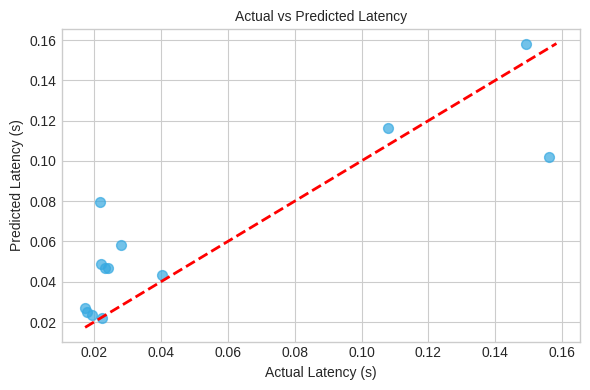

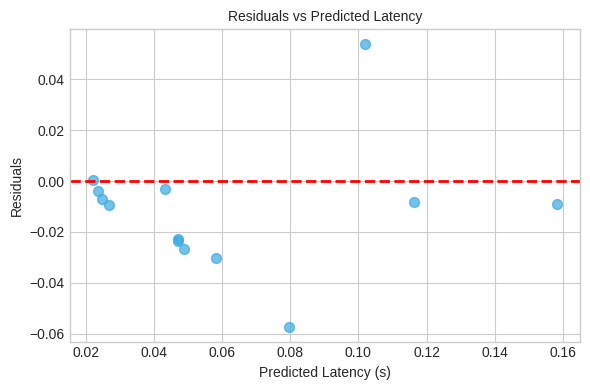

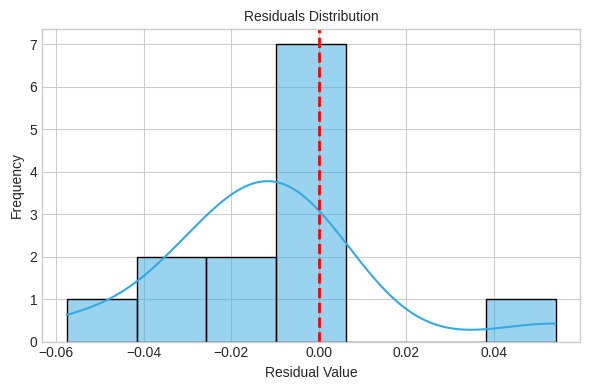

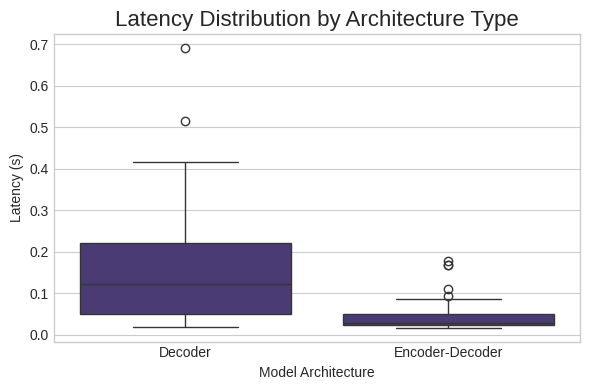

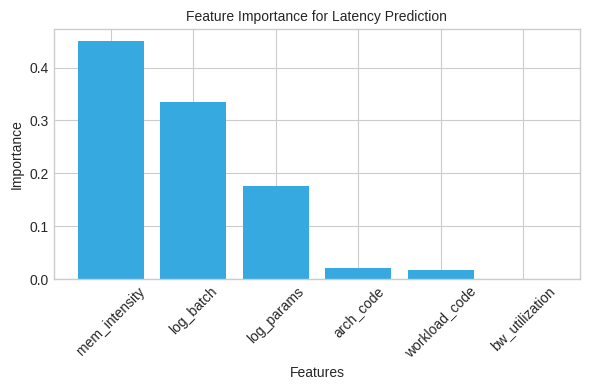

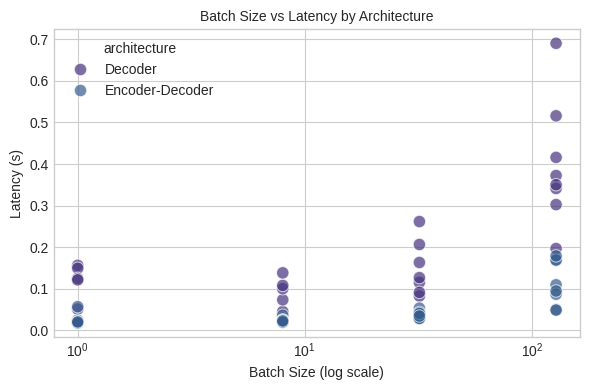


 Performance Prediction:
Latency: 0.11s
Peak Memory: 2.57 GB
Memory Bandwidth: 0.00 GB/s


In [ ]:
# ---------------------
# Part 4: Execution & Visualization
# ---------------------

if __name__ == "__main__":
    # Run profiling
    print("Starting Profiling...")
    profile_data = run_profiling_pipeline()

    # Initialize analyzer
    analyzer = LLMAnalyzer()

    # Train and evaluate
    print("\n Training Models...")
    metrics = analyzer.train_evaluate()

    # Show results
    print("\nEvaluation Metrics:")
    for target, scores in metrics.items():
        print(f"{target.upper():<15} | MAE: {scores['MAE']:.4f} | RMSE: {scores['RMSE']:.4f} | R²: {scores['R2']:.4f}")

    # Generate visualizations
    print("\nGenerating Visualizations...")
    analyzer.visualize_results()

    # Sample prediction
    sample_config = {
        'batch_size': 16,
        'parameters': 300_000_000,
        'architecture': 'Encoder-Decoder',
        'workload': 'translation'
    }
    prediction = analyzer.predict(sample_config)
    print("\n Performance Prediction:")
    print(f"Latency: {prediction['latency']:.2f}s")
    print(f"Peak Memory: {prediction['peak_memory']/1e9:.2f} GB")
    print(f"Memory Bandwidth: {prediction['memory_bandwidth']/1e9:.2f} GB/s")